In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torchaudio
import os
import glob
from torch.utils.data import Dataset, DataLoader
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import config

In [2]:
files = os.listdir("./data/unlabeled_test")

sr = []
for file in files:
    waveform, sample_rate = torchaudio.load("./data/unlabeled_test/"+file)
    sr.append(sample_rate)
sr

[32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,


In [3]:
class MyPipeline_pre(torch.nn.Module):
    def __init__(
        self,
        resample_freq=50000,
        n_fft=2048,
        device='cuda',
        hop_length = 512,
        n_mels=128,  
        win_length = 2048,
        window = 'hann',
        desired_length_in_seconds=5,
        train=True,
    ):
        super().__init__()
        
        self.train = train
        self.desired_length_in_seconds = desired_length_in_seconds
        self.sample_rate = resample_freq
        self.device = device
        

        # Create the mel spectrogram with a consistent number of mel frequency bins (n_mels=80)
        self.mel_spectrogram = T.MelSpectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,  
            win_length=win_length,
            window_fn=torch.hann_window
        ).to(device)

        
        self.amplitude = T.AmplitudeToDB().to(self.device)
        self.time_stretch = T.TimeStretch().to(self.device)

        
        self.additive_noise = T.Vol(1.1).to(self.device)  # Increase volume by 10% (for additive noise)
        self.volume_perturbation = T.Vol(0.9).to(self.device)  # Decrease volume by 10%

        self.spec_aug = torch.nn.Sequential( 
            T.FrequencyMasking(freq_mask_param=15).to(self.device),
            T.TimeMasking(time_mask_param=90).to(self.device),
            T.TimeStretch( random.uniform(0.95,1.05),fixed_rate=True).to(self.device)
        )

    

    """
    def fix_spectrogram_length(self, spec: torch.Tensor, target_length: int) -> torch.Tensor:
        
        Crop or pad the spectrogram to the target length.
        
        print(f"Shape of spec: {spec.shape}")
        current_length = spec.shape[1]

        if current_length == target_length:
            return spec
        elif current_length < target_length:
            padding_needed = target_length - current_length
            padding = (0, padding_needed)
            return torch.nn.functional.pad(spec, padding)
        else:
            start_idx = random.randint(0, current_length - target_length)
            return spec[:, start_idx:start_idx+target_length]
    """




    #@staticmethod
    def random_crop_or_pad(self, waveform: torch.Tensor, sample_rate, desired_length_in_seconds=5) -> torch.Tensor:
            """
            Randomly crops the waveform to the desired length in seconds.
            If the waveform is shorter than the desired length, it will be padded with zeros.
            """
            desired_length = desired_length_in_seconds * sample_rate
            current_length = waveform.shape[1]

            # If the waveform is shorter than desired, pad it with zeros
            side = random.randint(0,2)

            if current_length < desired_length:
                if side == 0:
                    padding_needed = desired_length - current_length
                    left_pad = padding_needed // 2
                    right_pad = padding_needed - left_pad
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
                elif side == 1:
                    padding_needed = desired_length - current_length
                    left_pad = padding_needed
                    right_pad = 0
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
                else:
                    padding_needed = desired_length - current_length
                    left_pad = 0
                    right_pad = padding_needed
                    waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
            
            # Calculate the starting point for cropping
            start_idx = random.randint(0, waveform.shape[1] - desired_length)
            return waveform[:, start_idx:start_idx+desired_length]

        #@staticmethod
    def random_crop_or_pad(self, waveform: torch.Tensor, sample_rate, desired_length_in_seconds=5) -> torch.Tensor:
            """
            Randomly crops the waveform to the desired length in seconds.
            If the waveform is shorter than the desired length, it will be padded with zeros.
            """
            desired_length = desired_length_in_seconds * sample_rate
            current_length = waveform.shape[1]
            padding_needed = desired_length - current_length

            # Pad waveform if it's shorter than desired
            if padding_needed > 0:
                # Randomly choose side to pad (0 for left, 1 for right)
                side = random.randint(0, 1)
                # Calculate padding for each side
                left_pad = padding_needed // 2 if side == 0 else padding_needed
                right_pad = padding_needed - left_pad
                waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
            # Crop waveform if it's longer than desired
            elif current_length > desired_length:
                start_idx = random.randint(0, current_length - desired_length)
                waveform = waveform[:, start_idx:start_idx + desired_length]

            return waveform
        



    def forward(self,sr, waveform: torch.Tensor,goal_r=32000) -> torch.Tensor:
        
        waveform = waveform.to(self.device)
        waveform = self.random_crop_or_pad(waveform, sr, self.desired_length_in_seconds)


        if sr != goal_r:
            resampler = T.Resample(orig_freq=sr, new_freq=goal_r).to(self.device)
            waveform = resampler(waveform)
    
        
        #t=0
        if self.train:
            '''
            if random.random() < 1:
                ps = T.PitchShift(sample_rate=sr,n_steps=0.1).to(self.device)
                waveform = ps(waveform)
            '''
            # Additive white noise
            if random.random() < 0.5:
                noise = torch.randn_like(waveform) * random.uniform(0.001, 0.004)
                waveform = waveform + self.additive_noise(noise)

            # Volume perturbation
            if random.random() < 0.5:
                waveform = self.volume_perturbation(waveform)
            '''
            #Time stretch without changing pitch
            if random.random() < 0.5 and t!=1:
                speed_factor = random.uniform(0.9, 1.1)
                resampler = T.Resample(
                orig_freq=self.sample_rate, new_freq=int(sr * speed_factor)
                ).to(self.device)
                waveform = resampler(waveform)
            '''
        # Convert to power spectrogram
        spec = self.mel_spectrogram(waveform)
        
        # Apply SpecAugment
        if self.train:
            spec = self.spec_aug(spec)

        # Convert to decibel
        spec = self.amplitude(spec).squeeze(0)
        spec = spec - spec.max()
        #spec = self.fix_spectrogram_length(spec, target_length=624)

        if config.channels == 3:
            spec = torch.stack([spec, spec, spec]) 

        

        return spec


class MyPipelinePreTrain(torch.nn.Module):
    def __init__(
        self,
        input_sample_rate,
        device,
        n_fft=2048,
        hop_length = 512,
        n_mels=128,  
        win_length = 2048,
        desired_length_in_seconds=5,
        train=True,
    ):
        super().__init__()
        
        self.train = train
        self.desired_length_in_seconds = desired_length_in_seconds
        self.sample_rate = input_sample_rate
        self.device = device  

        #Functions  
        self.mel_spectrogram = T.MelSpectrogram(
        sample_rate=input_sample_rate,  
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        win_length=win_length,
        window_fn=torch.hann_window  
        ).to(self.device)

        self.amplitude = T.AmplitudeToDB().to(self.device)
        self.time_stretch = T.TimeStretch().to(self.device)

        
        self.additive_noise = T.Vol(1.1).to(self.device)  # Increase volume by 10% (for additive noise)
        self.volume_perturbation = T.Vol(0.9).to(self.device)  # Decrease volume by 10%

        self.spec_aug = torch.nn.Sequential( 
            T.FrequencyMasking(freq_mask_param=10).to(self.device),#10
            T.TimeMasking(time_mask_param=90).to(self.device),#90
            #T.TimeStretch( random.uniform(0.95,1.05),fixed_rate=True).to(self.device)
        )

    #@staticmethod
    '''
    def random_crop_or_pad(self, waveform: torch.Tensor, sample_rate, desired_length_in_seconds=5) -> torch.Tensor:
        """
        Randomly crops the waveform to the desired length in seconds.
        If the waveform is shorter than the desired length, it will be padded with zeros.
        """
        desired_length = desired_length_in_seconds * sample_rate
        current_length = waveform.shape[1]
        padding_needed = desired_length - current_length

        # Pad waveform if it's shorter than desired
        if padding_needed > 0:
            # Randomly choose side to pad (0 for left, 1 for right)
            side = random.randint(0, 1)
            # Calculate padding for each side
            left_pad = padding_needed // 2 if side == 0 else padding_needed
            right_pad = padding_needed - left_pad
            waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
        # Crop waveform if it's longer than desired
        elif current_length > desired_length:
            start_idx = random.randint(0, current_length - desired_length)
            waveform = waveform[:, start_idx:start_idx + desired_length]

        return waveform
        '''
    def random_crop_or_pad(self, waveform: torch.Tensor, sample_rate, desired_length_in_seconds=5) -> torch.Tensor:
        """
        Randomly crops the waveform to the desired length in seconds.
        If the waveform is shorter than the desired length, it will be padded with zeros.
        """
        desired_length = desired_length_in_seconds * sample_rate
        current_length = waveform.shape[1]

        # If the waveform is shorter than desired, pad it with zeros
        side = random.randint(0,2)

        if current_length < desired_length:
            if side == 0:
                padding_needed = desired_length - current_length
                left_pad = padding_needed // 2
                right_pad = padding_needed - left_pad
                waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
            elif side == 1:
                padding_needed = desired_length - current_length
                left_pad = padding_needed
                right_pad = 0
                waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
            else:
                padding_needed = desired_length - current_length
                left_pad = 0
                right_pad = padding_needed
                waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
        
        # Calculate the starting point for cropping
        start_idx = random.randint(0, waveform.shape[1] - desired_length)
        return waveform[:, start_idx:start_idx+desired_length]
    
    def forward(self,sr, waveform: torch.Tensor,goal_r=50000) -> torch.Tensor:
        

        waveform = waveform.to(self.device)
        waveform = self.random_crop_or_pad(waveform, sr, self.desired_length_in_seconds)
        # Apply pitch shift

        if sr != goal_r:
            resampler = T.Resample(orig_freq=sr, new_freq=goal_r).to(self.device)
            waveform = resampler(waveform)
    
        
        #t=0
        if False:#self.train:
            # Additive white noise
            if random.random() < 0.5:
                noise = torch.randn_like(waveform) * random.uniform(0.001, 0.004)
                waveform = waveform + self.additive_noise(noise)

            # Volume perturbation
            if random.random() < 0.5:
                waveform = self.volume_perturbation(waveform)
            '''
            if random.random() < 1:
                ps = T.PitchShift(sample_rate=sr,n_steps=0.1).to(self.device)
                waveform = ps(waveform)

            #Time stretch without changing pitch
            if random.random() < 0.5 and t!=1:
                speed_factor = random.uniform(0.9, 1.1)
                resampler = T.Resample(
                orig_freq=self.sample_rate, new_freq=int(sr * speed_factor)
                ).to(self.device)
                waveform = resampler(waveform)
            '''

        
        # Convert to power spectrogram
        spec = self.mel_spectrogram(waveform)
        
        # Apply SpecAugment
        if self.train:
            spec = self.spec_aug(spec)

        # Convert to decibel
        spec = self.amplitude(spec).squeeze(0)
        #spec = spec - spec.max()

        if config.channels == 3:
            spec = torch.stack([spec, spec, spec]) 

        

        return spec
##############################################################################################################


31620
8044
length in seconds:  10.2
length in seconds:  10.112
torch.Size([3, 128, 586])


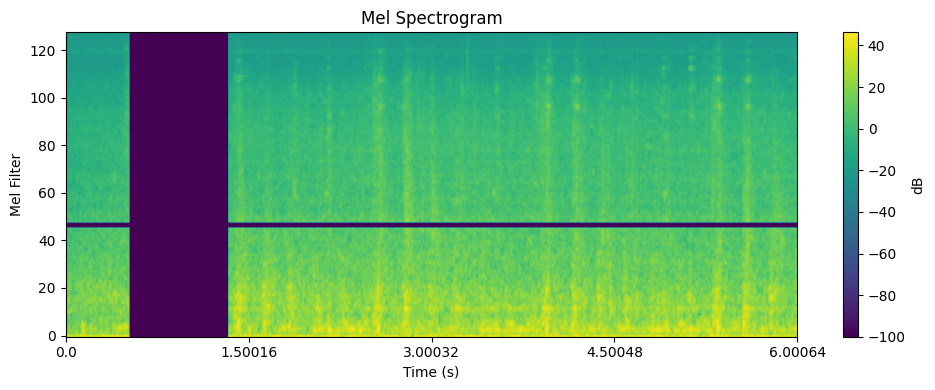

torch.Size([3, 128, 586])


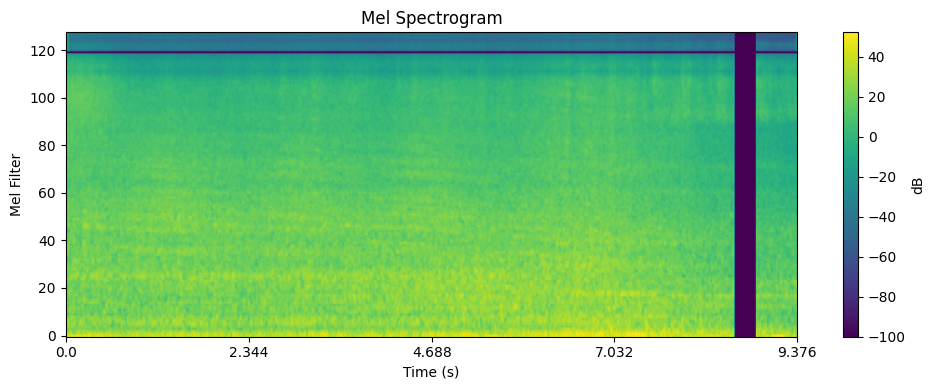

torch.Size([3, 128, 586])
torch.Size([3, 128, 586])
torch.Size([1, 128, 997])


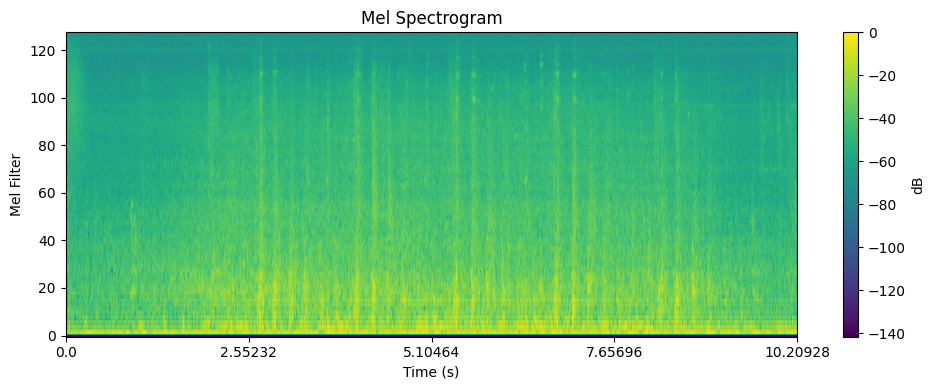

In [13]:

dir_path = 'G:/Dokumente/MAData/Unlabeled_all'

pipeline = MyPipelinePreTrain(desired_length_in_seconds=6, input_sample_rate=32000, device='cuda',n_mels=128)
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)

i=random.randint(0, len(os.listdir(dir_path)))
j=random.randint(0, len(os.listdir(dir_path)))

print(i)
print(j)

# Use the pipeline on the first file in the dataset
file_name = os.listdir(dir_path)[i]
path = os.path.join(dir_path, file_name)

# Load the file
waveform, sample_rate = torchaudio.load(path)
print("length in seconds: ", len(waveform[0]) / sample_rate)
waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)

file_name1 = os.listdir(dir_path)[j]
path1 = os.path.join(dir_path, file_name1)

# Load the file
waveform1, sample_rate1 = torchaudio.load(path1)
print("length in seconds: ", len(waveform1[0]) / sample_rate1)
waveform1 = waveform1.to(device=torch.device("cuda"), dtype=torch.float32)

mel_spec1 = pipeline(sample_rate,waveform)
mel_spec2 = pipeline(sample_rate1,waveform1)

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length):
    plt.figure(figsize=(10, 4))
    print(melspe_db.shape)
    # Convert tensor data to numpy for visualization
    melspe_db_np  = melspe_db[0].squeeze().cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')

    # Setting labels and title
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title('Mel Spectrogram')

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Set the hop length (change this if you specified a different value when computing the spectrogram)
 # Default in torchaudio
plot_mel_spectrogram(mel_spec1, sample_rate,hop_length=512)
plot_mel_spectrogram(mel_spec2, sample_rate1,hop_length=512)



print(mel_spec1.shape)
print(mel_spec2.shape)

import librosa
import librosa.display
import IPython.display
import numpy as np

w,s = librosa.load(path)
w1,s1 = librosa.load(path1)

w,s = torchaudio.load(path)
mel = T.MelSpectrogram(sample_rate=s, n_fft=1024, hop_length=512, n_mels=128)(w)
mel = T.AmplitudeToDB()(mel)
mel = mel - mel.max()

plot_mel_spectrogram(mel, s,hop_length=512)

#play the audio
IPython.display.Audio(data=w, rate=s)

IPython.display.Audio(data=w1, rate=s1)

In [7]:
# length of the audio
w,s = torchaudio.load(path)
print("length in seconds: ", len(w[0]) / s)

length in seconds:  8.3


In [26]:
mel_spec2

tensor([[[  44.6410,   43.5882,   44.9588,  ..., -100.0000, -100.0000,
          -100.0000],
         [  37.0441,   34.4358,   30.3033,  ..., -100.0000, -100.0000,
          -100.0000],
         [  37.4635,   35.9834,   29.6968,  ..., -100.0000, -100.0000,
          -100.0000],
         ...,
         [   2.5827,   -3.4266,  -26.7553,  ..., -100.0000, -100.0000,
          -100.0000],
         [   2.4925,   -3.5113,  -27.2050,  ..., -100.0000, -100.0000,
          -100.0000],
         [   2.4962,   -3.5136,  -27.0017,  ..., -100.0000, -100.0000,
          -100.0000]],

        [[  44.6410,   43.5882,   44.9588,  ..., -100.0000, -100.0000,
          -100.0000],
         [  37.0441,   34.4358,   30.3033,  ..., -100.0000, -100.0000,
          -100.0000],
         [  37.4635,   35.9834,   29.6968,  ..., -100.0000, -100.0000,
          -100.0000],
         ...,
         [   2.5827,   -3.4266,  -26.7553,  ..., -100.0000, -100.0000,
          -100.0000],
         [   2.4925,   -3.5113,  -27.205

In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torchaudio
import os
from torch.utils.data import Dataset, DataLoader
import random
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
# Implement Stratified K-Folds Cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#own modules
from Pipelines.Pipeline_FT_SA import MyPipeline
import config

root = './data/labeled_ADSMI/labeled_data_2013-535'
#root = 'E:/ADSIM/Import-2023-04/data/2015-606/Heiligenstadt_2015_01_Data'
filenames = os.listdir(root)


n = len(filenames)
f = len(config.ADSMI_train_folds)+1 # replace with your desired value of f

# Compute quotient and remainder
q, r = divmod(n, f)

# Create the list
FOLDS = []
for i in range(1, f + 1):
    FOLDS.extend([i] * q)

# Add the remainder elements
for i in range(1, r + 1):
    FOLDS.append(i)

random.shuffle(FOLDS)
random.shuffle(FOLDS)
random.shuffle(FOLDS)




files_df = pd.DataFrame(data = {
    "filename": filenames,
    "folds": FOLDS
})



In [6]:


class MyDataset_pretrain_train(Dataset):
    
    def __init__(self, files_df,train=True, desired_length_in_seconds=7):
        self.root = './data/labeled_ADSMI/labeled_data_2013-535/'
        
        #getting name of all files inside the all of the train_folds
        temp = os.listdir(self.root)
        temp.sort()
        self.file_names = []
        self.class_ids = []
        self.train = train
        
        if self.train:
            self.files_df = files_df[files_df["folds"].isin(config.ADSMI_train_folds)]
            self.file_names = files_df["filename"].values
        else:
            self.files_df = files_df[files_df["folds"].isin(config.ADSMI_test_fold)]
            self.file_names = files_df["filename"].values

        
        self.pipeline = MyPipeline_pre(desired_length_in_seconds=desired_length_in_seconds)
        self.pipeline.to(device=torch.device("cuda"), dtype=torch.float32)    

    def __len__(self):
        return len(self.file_names)
    


    def __getitem__(self, index):

        file_name = self.file_names[index]  
        path = self.root + file_name

        file_name_neg = self.file_names[random.randint(0, len(self.file_names) - 1)]
        while file_name_neg == file_name:
            file_name_neg = self.file_names[random.randint(0, len(self.file_names) - 1)]
        path_neg = self.root + file_name_neg


        # Using torchaudio to load waveform
        waveform1, sample_rate1 = torchaudio.load(path)
        waveform1 = waveform1.to(device=torch.device("cuda"), dtype=torch.float32)
        #print(waveform1)
        waveform2, sample_rate2 = torchaudio.load(path_neg)
        waveform2 = waveform2.to(device=torch.device("cuda"), dtype=torch.float32)

        anchor = self.pipeline(sample_rate1,waveform1 )
        pos =  self.pipeline(sample_rate1,waveform1)
        neg =  self.pipeline(sample_rate2,waveform2 )
        


        return anchor, pos, neg






def create_generators_pretrain(files_df):
    train_dataset = MyDataset_pretrain_train(files_df, desired_length_in_seconds=config.desired_length_in_seconds)
    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)

    test_dataset = MyDataset_pretrain_train(files_df,train=False, desired_length_in_seconds=config.desired_length_in_seconds)
    test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)
    
    return train_loader, test_loader



In [7]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # L2 normalize the embeddings
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()

In [8]:
print(config.channels)

class ContrastiveTripletModel(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer (with 50% probability, adjust as needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


In [9]:
patience = 30  # or whatever value you deem appropriate
early_stop_counter = 0



print(config.epochs)
print(config.batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialization
model = ContrastiveTripletModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

# Data
train_loader, test_loader = create_generators_pretrain(files_df,)

epochs = config.epochs
training_losses = []
validation_losses = []


best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)

        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

300
32


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/148 [00:07<?, ?it/s]


KeyboardInterrupt: 